In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.patches as mpatches
from scipy.stats import t
from itertools import combinations
from math import factorial
from scipy.stats import bootstrap

In [2]:
def stripper(x, length):
    dummy = []
    for i in x.strip().strip('[]').split():
        single = i.strip('\n')
        if single.isspace():
            continue
        if len(single) == 0:
            continue
        try:
            temp = float(single)
            dummy.append(temp)
        except:
            print(f"Warning: Couldn't convert {single} to float.")
    if len(dummy) != length:
        print(f"Warning: Only {len(dummy)} values were converted.")
    return dummy

In [5]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes two-sided paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = 2 * t.sf(np.abs(t_stat), df)  # two-sided t-test
    return t_stat, p_val

In [200]:
combinations = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.95, 0.98, 1.0]
III14 = pd.DataFrame(index=thresholds, columns=combinations)
III14_err = pd.DataFrame(index=thresholds, columns=combinations)
III14_vec = pd.DataFrame(index=thresholds, columns=combinations)
C1 = pd.DataFrame(index=thresholds, columns=combinations)
C1_err = pd.DataFrame(index=thresholds, columns=combinations)
C1_vec = pd.DataFrame(index=thresholds, columns=combinations)
C28 = pd.DataFrame(index=thresholds, columns=combinations)
C28_err = pd.DataFrame(index=thresholds, columns=combinations)
C28_vec = pd.DataFrame(index=thresholds, columns=combinations)
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"
for threshold in thresholds:
    maindir = f"{result_dir}/threshold{threshold}/multitaskSVM"
    for combination in combinations:
        ana_dir = f"{maindir}/whole/{combination}/RNCV"
        fn = os.path.join(ana_dir, "collected_key_results.tsv")
        temp =  pd.read_csv(fn, sep='\t', index_col=0)
        III14.loc[threshold, combination] = temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C1.loc[threshold, combination] = temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C28.loc[threshold, combination] = temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

        III14_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C1_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C28_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)

        III14_vec.loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0])
        C1_vec.loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0])
        C28_vec.loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0])

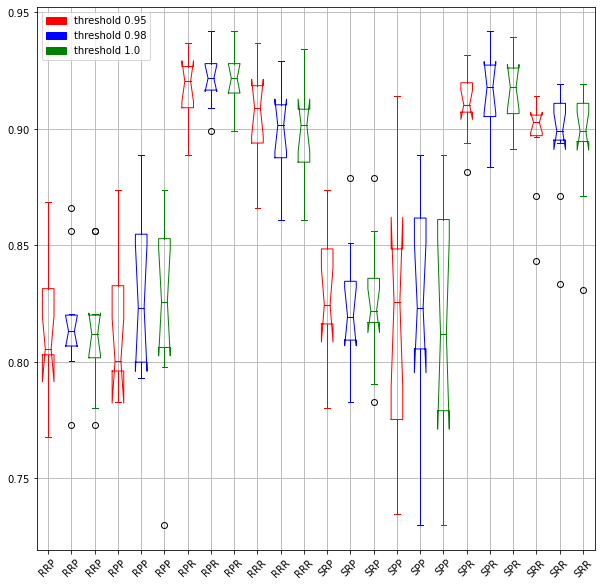

In [204]:
III14_vec.transpose()[0.95].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(1, 25, 3), notch=True, color='r', labels=['0.95' for x in range(0, 8)])
III14_vec.transpose()[0.98].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(2, 25, 3), notch=True, color='b', labels=['0.98' for x in range(0, 8)])
III14_vec.transpose()[1.0].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(3, 25, 3), notch=True, color='g', labels=['1.0' for x in range(0, 8)])
red_patch = mpatches.Patch(color='red', label='threshold 0.95')
blue_patch = mpatches.Patch(color='blue', label='threshold 0.98')
green_patch = mpatches.Patch(color='green', label='threshold 1.0')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()
plt.close()

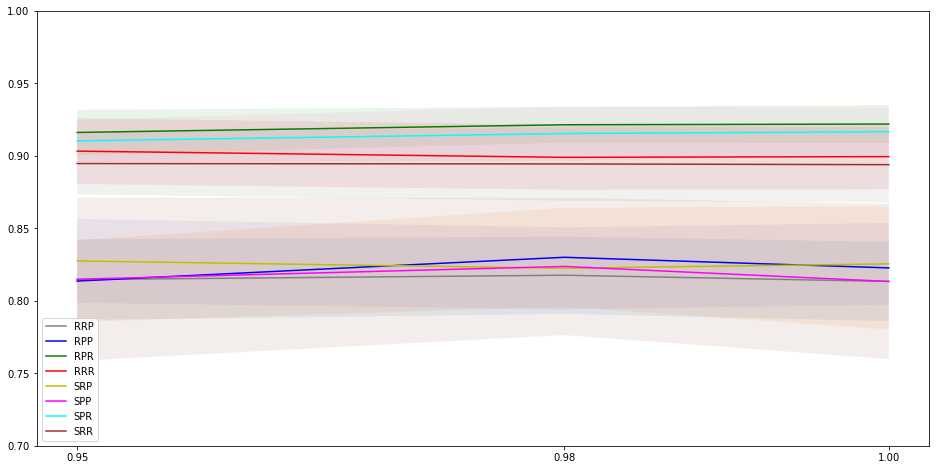

In [206]:
colors=['gray','b','g','r','y','magenta','cyan','brown']
plt.figure(figsize=(16, 8))
for column, color in zip(III14.columns, colors):
    plt.plot(III14.index, III14[column], color=color, label=column)
    plt.fill_between(III14.index, III14[column].to_numpy(dtype=float) - III14_err[column].to_numpy(dtype=float), III14[column].to_numpy(dtype=float) + III14_err[column].to_numpy(dtype=float), alpha=0.1)
    plt.ylim((0.7, 1))
    plt.xticks(III14.index)
    plt.legend()
plt.show()
plt.close()

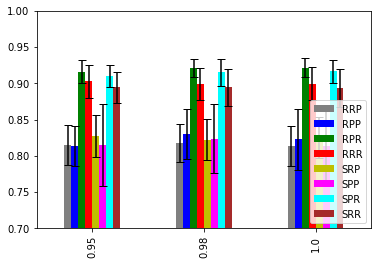

In [205]:
III14.plot(kind='bar', yerr=III14_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

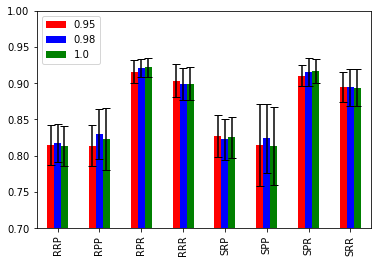

In [209]:
III14.transpose().plot(kind='bar', yerr=III14_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

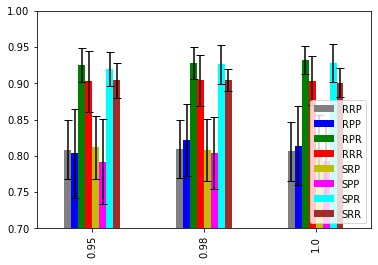

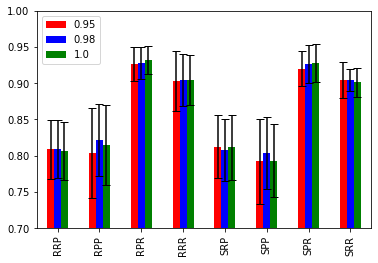

In [210]:
C1.plot(kind='bar', yerr=C1_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C1.transpose().plot(kind='bar', yerr=C1_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

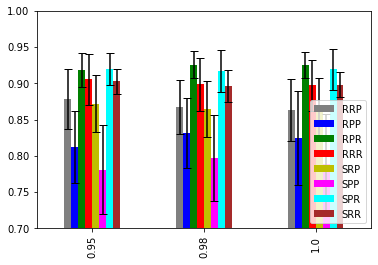

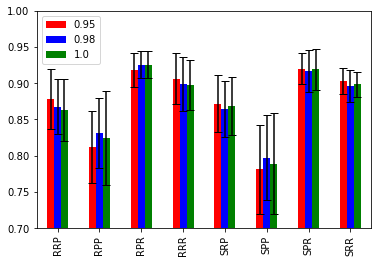

In [211]:
C28.plot(kind='bar', yerr=C28_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C28.transpose().plot(kind='bar', yerr=C28_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

In [214]:
combinations = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.95, 0.98, 1.0]
III14s = pd.DataFrame(index=thresholds, columns=combinations)
C1s = pd.DataFrame(index=thresholds, columns=combinations)
C28s = pd.DataFrame(index=thresholds, columns=combinations)
III14s_err = pd.DataFrame(index=thresholds, columns=combinations)
C1s_err = pd.DataFrame(index=thresholds, columns=combinations)
C28s_err = pd.DataFrame(index=thresholds, columns=combinations)
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"
for threshold in thresholds:
    maindir = f"{result_dir}/threshold{threshold}/multitaskSVM"
    for combination in combinations:
        ana_dir = f"{maindir}/whole/{combination}/RNCV"
        fn = os.path.join(ana_dir, "collected_key_results.tsv")
        temp =  pd.read_csv(fn, sep='\t', index_col=0)
        III14s.loc[threshold, combination] = temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C1s.loc[threshold, combination] = temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C28s.loc[threshold, combination] = temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        III14s_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C1s_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C28s_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)

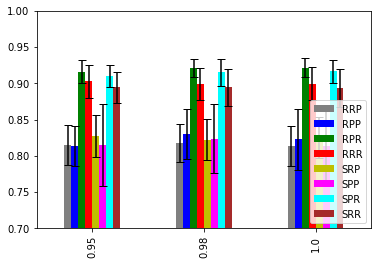

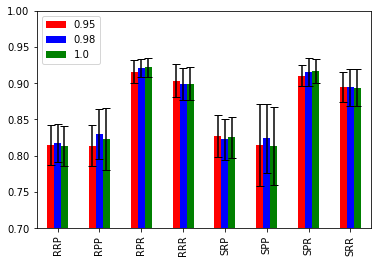

In [215]:
III14s.plot(kind='bar', yerr=III14s_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

III14s.transpose().plot(kind='bar', yerr=III14s_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

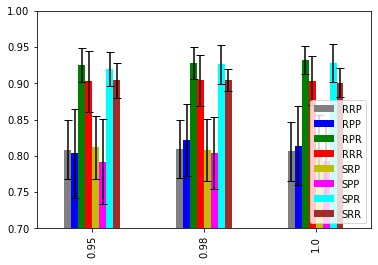

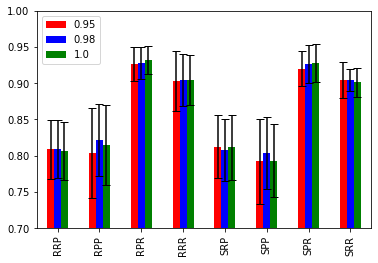

In [216]:
C1s.plot(kind='bar', yerr=C1s_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C1s.transpose().plot(kind='bar', yerr=C1s_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

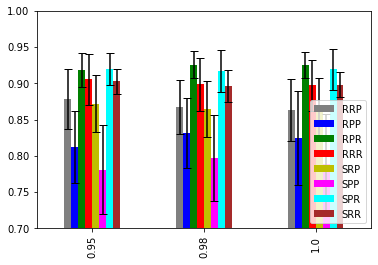

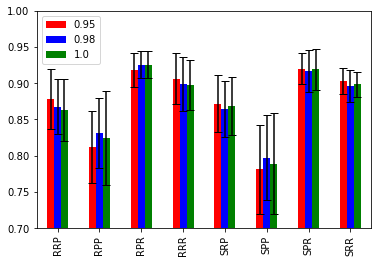

In [217]:
C28s.plot(kind='bar', yerr=C28s_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C28s.transpose().plot(kind='bar', yerr=C28s_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

In [4]:
combis = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
times = ['III14', 'C-1', 'C28']
results = {
    'whole': {
        'III14_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_std': pd.DataFrame(index=thresholds, columns=columns),
        'III14_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_std': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C28_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_std': pd.DataFrame(index=thresholds, columns=columns),
        'C28_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test': pd.DataFrame(index=thresholds, columns=columns),
    },
    'selective': {
        'III14_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_std': pd.DataFrame(index=thresholds, columns=columns),
        'III14_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_std': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C28_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_std': pd.DataFrame(index=thresholds, columns=columns),
        'C28_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test': pd.DataFrame(index=thresholds, columns=columns),
    },
}
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"

for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
            if method == 'multitaskSVM':
                for combination in combis:
                    ana_dir = f"{maindir}/{dataset}/{combination}/RNCV"
                    fn = os.path.join(ana_dir, "collected_key_results.tsv")
                    try:
                        temp =  pd.read_csv(fn, sep='\t', index_col=0)
                    except:
                        print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}.")
                        continue
                    for time in times:
                        results[dataset][f'{time}_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                        results[dataset][f'{time}_std'].loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10), ddof=1)

                        ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                        results[dataset][f'{time}_conf'].loc[threshold, combination] = [ci_l, ci_u]

                        results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                        results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

            else:
                ana_dir = f"{maindir}/{dataset}/RNCV"
                fn = os.path.join(ana_dir, "collected_key_results.tsv")
                try:
                    temp =  pd.read_csv(fn, sep='\t', index_col=0)
                except:
                    print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}.")
                    continue
                for time in times:
                    results[dataset][f'{time}_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                    results[dataset][f'{time}_std'].loc[threshold, method] = np.std(stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10), ddof=1)

                    ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                    results[dataset][f'{time}_conf'].loc[threshold, method] = [ci_l, ci_u]

                    results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                    results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

In [5]:
results['whole']['III14_conf']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,SRP,SPP,SPR,SRR
0.70,"[0.7582504273261795, 0.8333159675383334]","[0.7827074971134469, 0.852272726]","[0.694949494, 0.765151516]","[0.7280303060000001, 0.776767677]","[0.7623737389999999, 0.8128825682057934]","[0.8964646460000001, 0.9141414149999999]","[0.880050505, 0.9037525691171615]","[0.7202020200000001, 0.777020203]","[0.748737372, 0.8047979780000001]","[0.898737372, 0.9161616135655659]","[0.883838384, 0.904292931]"
0.75,"[0.765909089, 0.8191919200000001]","[0.792596356375325, 0.8579545449999999]","[0.5607323211348204, 0.6584607321964288]","[0.730555554, 0.7808080820000001]","[0.7751701026800571, 0.8242992427455348]","[0.899747473, 0.9199494940000001]","[0.8929292924355879, 0.9267676760000001]","[0.7487373719999999, 0.8025554060220188]","[0.773232325, 0.823232325]","[0.902272726, 0.9217171719999999]","[0.8934343440000001, 0.9186868670000001]"
0.80,"[0.746843436, 0.7936868690000001]","[0.7652777780780708, 0.828282827]","[0.5186868710000001, 0.6331619451414703]","[0.744949495, 0.792171719]","[0.7782828289999999, 0.8242424240000001]","[0.901767675, 0.916161617]","[0.8909090911869826, 0.9156565649999999]","[0.763383838, 0.7929292936372171]","[0.764898989, 0.818686868]","[0.8957070720000001, 0.919949496856911]","[0.880555556, 0.9042929310000001]"
0.85,"[0.717424241, 0.7609848478419982]","[0.7744949510000001, 0.82954545477135]","[0.494823231260822, 0.5994949488112494]","[0.7669191929999999, 0.802525253]","[0.770707072, 0.8191919220000001]","[0.888131314, 0.9126262630000002]","[0.872474746, 0.897979798]","[0.765909093, 0.80858586]","[0.7810606087491403, 0.834090909]","[0.8939393950000001, 0.9055555569999999]","[0.867424242, 0.8934343404840265]"
0.90,"[0.709217172, 0.753787879]","[0.737373739, 0.820328284]","[0.449025728203894, 0.5745733168147154]","[0.775757576, 0.8116161639999999]","[0.7777777810000001, 0.831688074512212]","[0.894444444, 0.9116161609999999]","[0.8954545429999999, 0.9212121200000001]","[0.7671717169999999, 0.8113636359999999]","[0.780050506, 0.8343434341915732]","[0.8979797959999999, 0.916666667]","[0.89520202, 0.9141414130000001]"
0.95,"[0.696717172, 0.7430555559254718]","[0.72651515, 0.8183080790112589]","[0.4767676788932835, 0.6084595955574663]","[0.777272728, 0.8183757368377124]","[0.7815656590000001, 0.842929296]","[0.898737373, 0.914646466]","[0.8919191919999999, 0.918434342]","[0.773737373, 0.823484848]","[0.7833333330000001, 0.8446969708401301]","[0.90151515, 0.9176767680000001]","[0.8977272720000001, 0.9196969669999999]"
1.00,"[0.7131313150000002, 0.747222224]","[0.7430555560000001, 0.827777778]","[0.49760100900000004, 0.6079464268565306]","[0.7984848480099713, 0.830555558]","[0.7921717189999999, 0.843181819]","[0.914141412, 0.9293348811857636]","[0.8861111100000001, 0.912373737]","[0.81010101, 0.843181819]","[0.781060608, 0.8431818200000001]","[0.906565655, 0.925757576]","[0.870202019, 0.9047979789999999]"


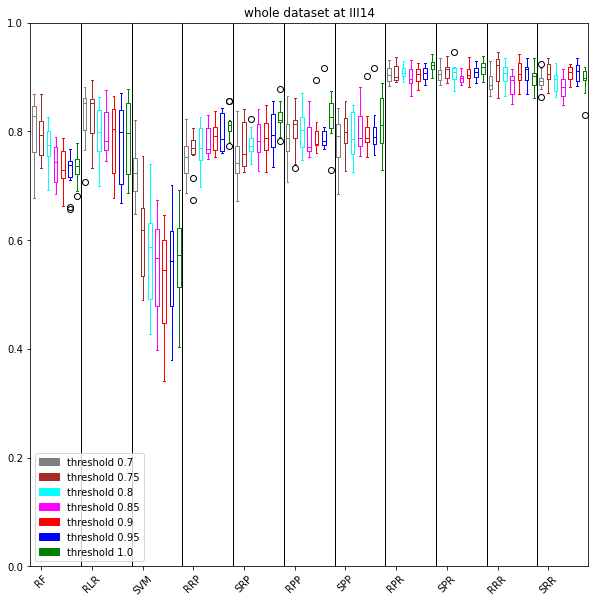

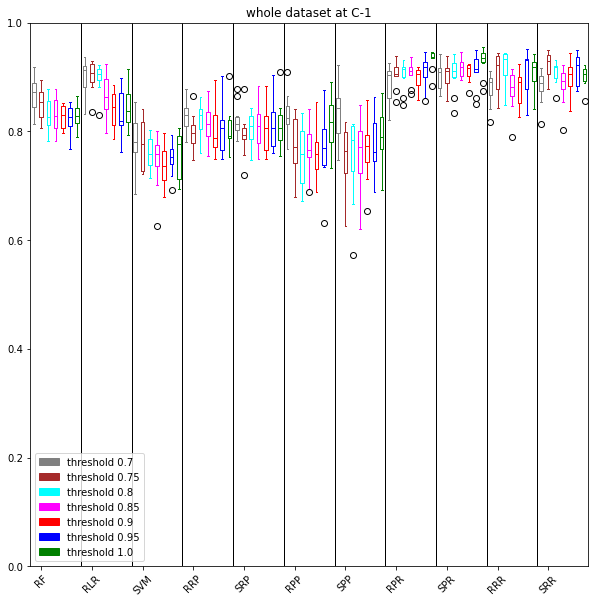

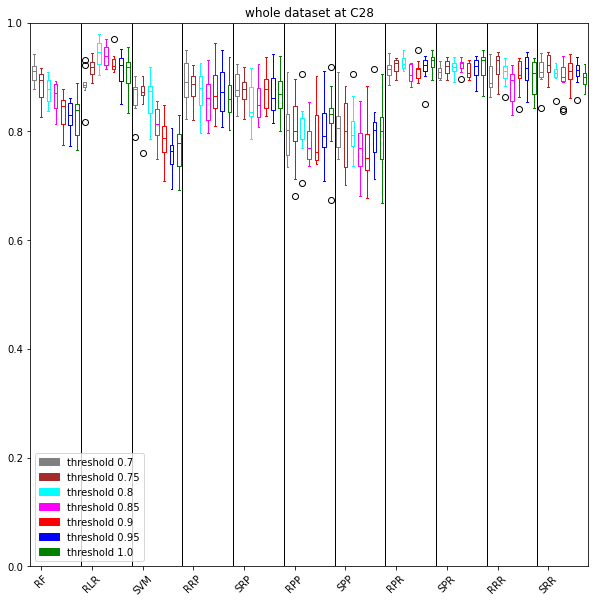

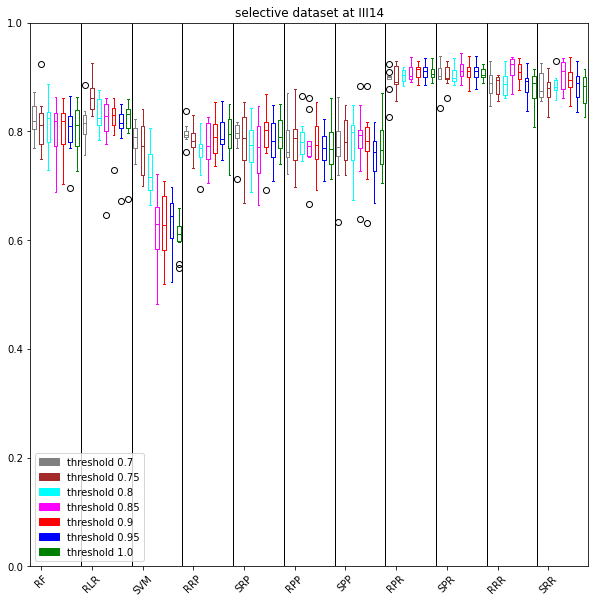

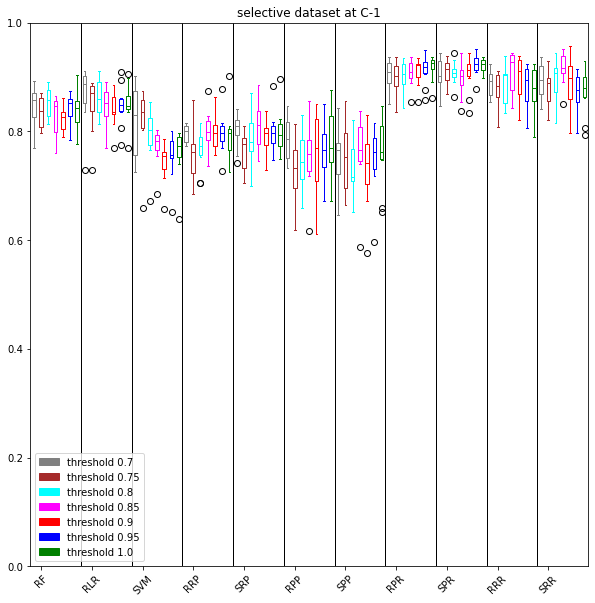

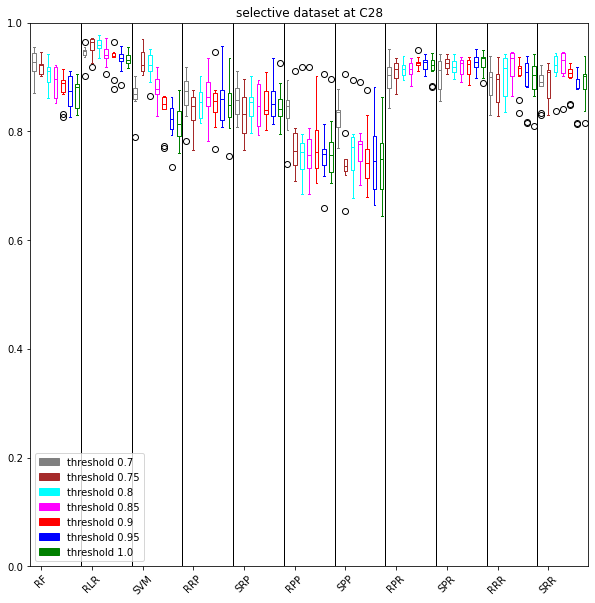

In [6]:
# new
columns = ['RF', 'RLR', 'SVM', 'RRP', 'SRP', 'RPP', 'SPP', 'RPR', 'SPR', 'RRR', 'SRR']
for dataset in ['whole', 'selective']:
    for time in times:
        results[dataset][f'{time}_ncv'].loc[0.7, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(1, 78, 7), notch=False, color='grey', labels=['0.7' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.75, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(2, 78, 7), notch=False, color='brown', labels=['0.75' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.8, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(3, 78, 7), notch=False, color='cyan', labels=['0.8' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.85, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(4, 78, 7), notch=False, color='magenta', labels=['0.85' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.9, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(5, 78, 7), notch=False, color='r', labels=['0.9' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.95, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(6, 78, 7), notch=False, color='b', labels=['0.95' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].loc[1.0, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(7, 78, 7), notch=False, color='g', labels=['1.0' for x in range(0, 11)], grid=False)
        grey_patch = mpatches.Patch(color='grey', label='threshold 0.7')
        brown_patch = mpatches.Patch(color='brown', label='threshold 0.75')
        cyan_patch = mpatches.Patch(color='cyan', label='threshold 0.8')
        magenta_patch = mpatches.Patch(color='magenta', label='threshold 0.85')
        red_patch = mpatches.Patch(color='red', label='threshold 0.9')
        blue_patch = mpatches.Patch(color='blue', label='threshold 0.95')
        green_patch = mpatches.Patch(color='green', label='threshold 1.0')
        for i in range(7, 78, 7):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(2, 77, 7))
        plt.ylim((0, 1))
        plt.legend(handles=[grey_patch, brown_patch, cyan_patch, magenta_patch, red_patch, blue_patch, green_patch])
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

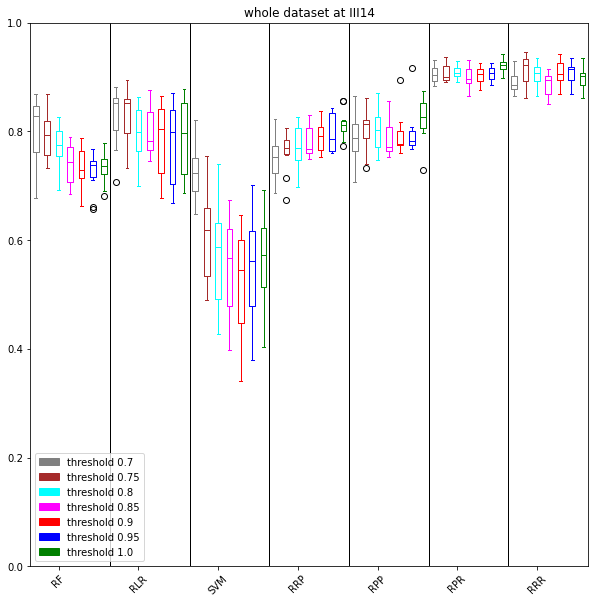

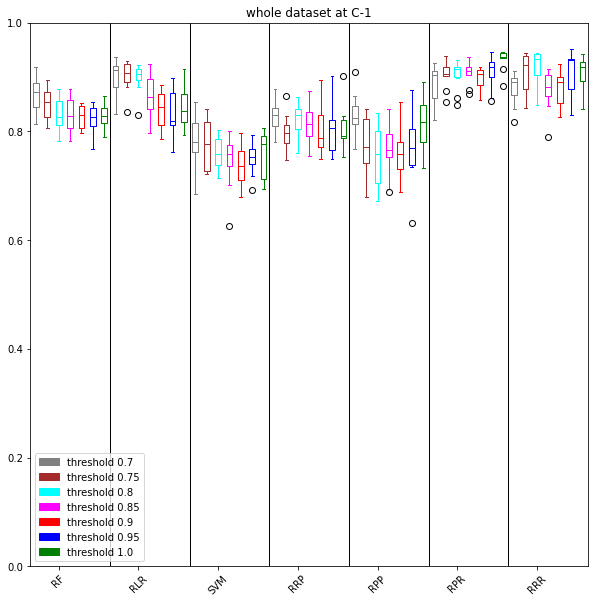

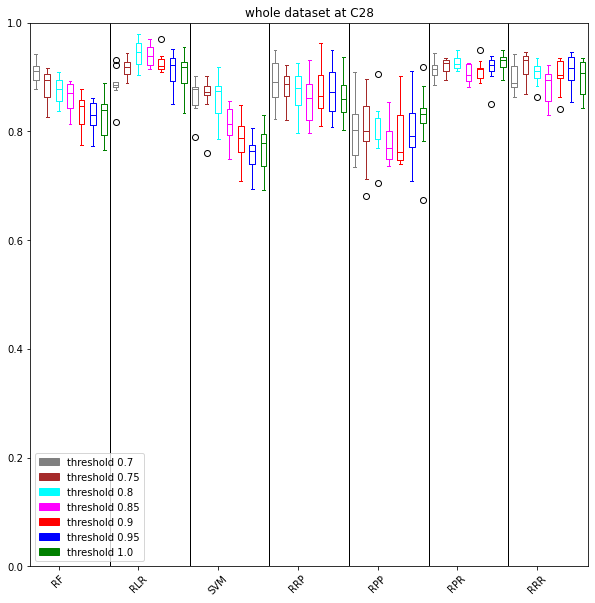

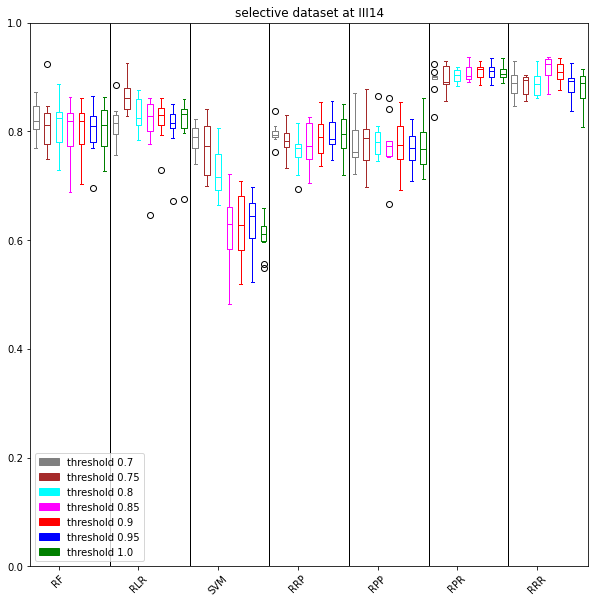

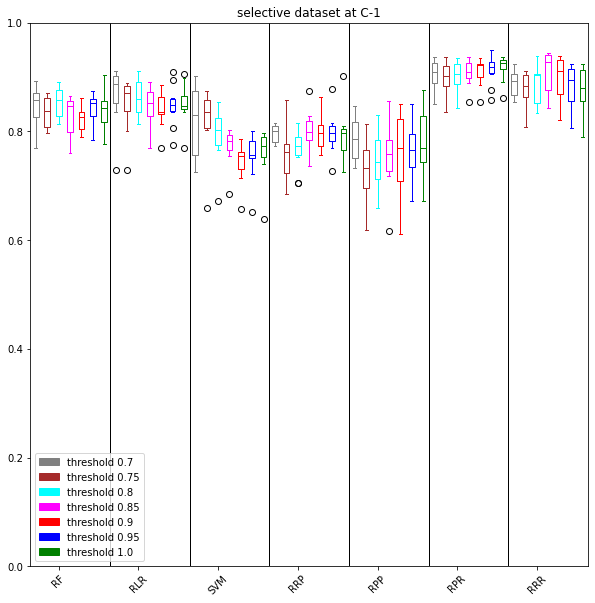

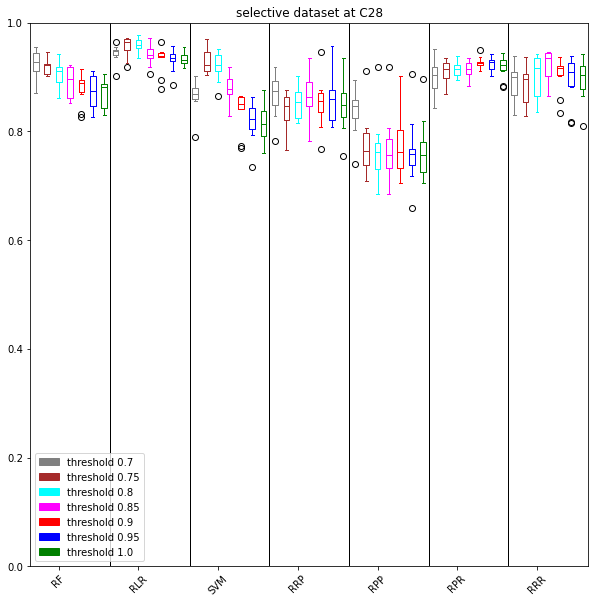

In [7]:
# new
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR']
for dataset in ['whole', 'selective']:
    for time in times:
        results[dataset][f'{time}_ncv'].loc[0.7, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(1, 50, 7), notch=False, color='grey', labels=['0.7' for x in range(0, 7)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.75, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(2, 50, 7), notch=False, color='brown', labels=['0.75' for x in range(0, 7)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.8, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(3, 50, 7), notch=False, color='cyan', labels=['0.8' for x in range(0, 7)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.85, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(4, 50, 7), notch=False, color='magenta', labels=['0.85' for x in range(0, 7)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.9, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(5, 50, 7), notch=False, color='r', labels=['0.9' for x in range(0, 7)], grid=False)
        results[dataset][f'{time}_ncv'].loc[0.95, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(6, 50, 7), notch=False, color='b', labels=['0.95' for x in range(0, 7)], grid=False)
        results[dataset][f'{time}_ncv'].loc[1.0, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(7, 50, 7), notch=False, color='g', labels=['1.0' for x in range(0, 7)], grid=False)
        grey_patch = mpatches.Patch(color='grey', label='threshold 0.7')
        brown_patch = mpatches.Patch(color='brown', label='threshold 0.75')
        cyan_patch = mpatches.Patch(color='cyan', label='threshold 0.8')
        magenta_patch = mpatches.Patch(color='magenta', label='threshold 0.85')
        red_patch = mpatches.Patch(color='red', label='threshold 0.9')
        blue_patch = mpatches.Patch(color='blue', label='threshold 0.95')
        green_patch = mpatches.Patch(color='green', label='threshold 1.0')
        for i in range(7, 50, 7):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(3, 49, 7))
        plt.ylim((0, 1))
        plt.legend(handles=[grey_patch, brown_patch, cyan_patch, magenta_patch, red_patch, blue_patch, green_patch])
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [6]:
# corrected

n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.158        0.511      0.330
1     RPR     RRP   3.101  0.019       0.001        0.997      0.002
2     RPR     RPP   2.384  0.126       0.006        0.982      0.013
3     RRR     RRP   2.928  0.031       0.001        0.995      0.004
4     RRR     RPP   2.047  0.276       0.014        0.962      0.024
5     RRP     RPP  -0.479  1.000       0.595        0.239      0.166

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.158        0.511      0.330
1     RPR     RRP   3.101  0.019       0.001        0.997      0.002
2     RPR     RPP   2.384  0.126       0.006        0.982      0.013
3     RRR     RRP   2.928  0.031       0.001        0.995      0.004
4     RRR     RPP   2.047  0.276       0.014        0.962      0.024
5     RRP     RPP  -0.479  1.000       0.595        0.239      0.166

whole C28


In [7]:
# uncorrected bayesian

n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=np.std(differences, ddof=1)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.373        0.504      0.123
1     RPR     RRP   3.101  0.019       0.143        0.817      0.040
2     RPR     RPP   2.384  0.126       0.202        0.753      0.045
3     RRR     RRP   2.928  0.031       0.155        0.802      0.044
4     RRR     RPP   2.047  0.276       0.234        0.719      0.047
5     RRP     RPP  -0.479  1.000       0.531        0.410      0.060

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.373        0.504      0.123
1     RPR     RRP   3.101  0.019       0.143        0.817      0.040
2     RPR     RPP   2.384  0.126       0.202        0.753      0.045
3     RRR     RRP   2.928  0.031       0.155        0.802      0.044
4     RRR     RPP   2.047  0.276       0.234        0.719      0.047
5     RRP     RPP  -0.479  1.000       0.531        0.410      0.060

whole C28


In [8]:
# corrected

n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C28


In [9]:
# uncorrected bayesian

n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=np.std(differences, ddof=1)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.110        0.861      0.029
1     RPR     RLR   1.350  1.000       0.222        0.734      0.044
2     RPR     SVM   3.154  0.016       0.050        0.942      0.008
3      RF     RLR  -0.936  1.000       0.658        0.288      0.054
4      RF     SVM   1.700  0.572       0.182        0.800      0.017
5     RLR     SVM   2.079  0.257       0.136        0.850      0.014

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.110        0.861      0.029
1     RPR     RLR   1.350  1.000       0.222        0.734      0.044
2     RPR     SVM   3.154  0.016       0.050        0.942      0.008
3      RF     RLR  -0.936  1.000       0.658        0.288      0.054
4      RF     SVM   1.700  0.572       0.182        0.800      0.017
5     RLR     SVM   2.079  0.257       0.136        0.850      0.014

whole C28
